# Data processing NDVI

In [2]:
import pandas as pd
import scipy as sp
import numpy as np
import rasterio
import os
import geopandas as gpd
import random
import matplotlib.pyplot as plt
import time
from scipy.ndimage import convolve
from scipy.signal import fftconvolve
from rasterio.transform import from_origin
from rasterio.plot import show
from shapely.geometry import box, Point, Polygon
from osgeo import gdal
from geopandas import GeoSeries
from geopandas.tools import sjoin
from numpy.random import RandomState
from skimage.filters.rank import modal
from skimage.util import img_as_ubyte
from PIL import Image as im

%matplotlib inline

In [2]:
#!pip install scikit-learn
#!pip install -U scikit-image

# 1. Normalized difference vegetation index (NDVI)

## 1.1. Step 1: processing NDVI input image

In [2]:
# data dir
data_dir = r"thesis_project/data"
fp = os.path.join(data_dir, "CR_NDVI.TIF")

# open the file
ndvi_input_raster = rasterio.open(fp)

# check type of the variable 'raster'
type(ndvi_input_raster)

rasterio.io.DatasetReader

In [3]:
# check metadata for the whole raster dataset
ndvi_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.3999999521443642e+38,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

In [4]:
# check boundaries raster
ndvi_input_raster.bounds

BoundingBox(left=341660.6724, bottom=371164.6389, right=416090.6724, top=431034.6389)

In [5]:
# read the raster band as separate variable
ndvi_input = ndvi_input_raster.read(1)
type(ndvi_input)

numpy.ndarray

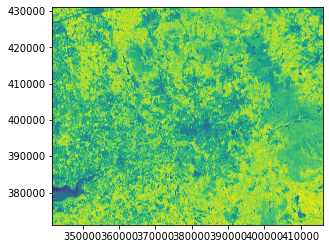

<AxesSubplot:>

In [20]:
# plot input NDVI
show(ndvi_input_raster, 1)

## 1.2. Step 2: focal statistics analysis

### 1.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [8]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
ndvi_filter_100 = np.ones((21, 21))
ndvi_filter_100.shape

(21, 21)

In [9]:
# convolve filter (i.e. buffer zone) over the whole NDVI image using FFT and average NDVI values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
ndvi_output_100 = fftconvolve(ndvi_input, ndvi_filter_100, mode = "same") / np.sum(ndvi_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_100.shape

--- 2.6263129711151123 seconds ---


(5987, 7443)

### 1.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [10]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
ndvi_filter_300 = np.ones((61, 61))
ndvi_filter_300.shape

(61, 61)

In [11]:
# convolve filter (i.e. buffer zone) over the whole NDVI image using FFT and average NDVI values 
start_time = time.time()
ndvi_output_300 = fftconvolve(ndvi_input, ndvi_filter_300, mode = "same") / np.sum(ndvi_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_300.shape

--- 2.7162387371063232 seconds ---


(5987, 7443)

### 1.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [12]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
ndvi_filter_500 = np.ones((101, 101))
ndvi_filter_500.shape

(101, 101)

In [13]:
# convolve filter (i.e. buffer zone) over the whole NDVI image using FFT and average NDVI values
start_time = time.time()
ndvi_output_500 = fftconvolve(ndvi_input, ndvi_filter_500, mode = "same") / np.sum(ndvi_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
ndvi_output_500.shape

--- 2.7865211963653564 seconds ---


(5987, 7443)

## 1.3. Step 3: development of NDVI exposure maps

### 1.3.1. NDVI map capturing exposure for a buffer zone of 100 m

In [14]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_100.tif', 'w', driver='GTiff',
                            height = ndvi_output_100.shape[0], width = ndvi_output_100.shape[1],
                            count=1, dtype=str(ndvi_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_100, 1)
new_dataset.close()

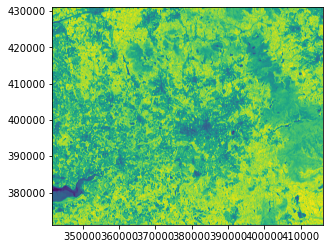

--- 2.166384696960449 seconds ---


In [15]:
# NDVI exposure map at 100 m
start_time = time.time()
ndvi_src_100 = rasterio.open("thesis_project/output/layers/ndvi_output_100.tif")
show(ndvi_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [16]:
# output layer metadata
ndvi_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.2. NDVI map capturing exposure for a buffer zone of 300 m

In [17]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_300.tif', 'w', driver='GTiff',
                            height = ndvi_output_300.shape[0], width = ndvi_output_300.shape[1],
                            count=1, dtype=str(ndvi_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_300, 1)
new_dataset.close()

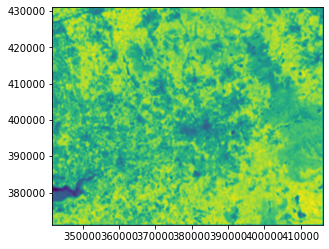

--- 2.17838191986084 seconds ---


In [18]:
# NDVI exposure map at 300 m
start_time = time.time()
ndvi_src_300 = rasterio.open("thesis_project/output/layers/ndvi_output_300.tif")
show(ndvi_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [19]:
# check meta
ndvi_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

### 1.3.3. NDVI map capturing exposure for a buffer zone of 500 m

In [20]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(341660.6724, 431034.6389, 10.0, 10.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/ndvi_output_500.tif', 'w', driver='GTiff',
                            height = ndvi_output_500.shape[0], width = ndvi_output_500.shape[1],
                            count=1, dtype=str(ndvi_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(ndvi_output_500, 1)
new_dataset.close()

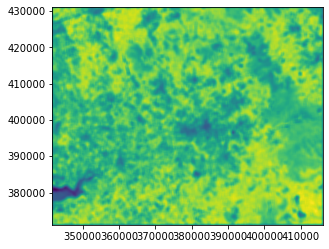

--- 2.225801944732666 seconds ---


In [21]:
# NDVI exposure map at 500 m
start_time = time.time()
ndvi_src_500 = rasterio.open("thesis_project/output/layers/ndvi_output_500.tif")
show(ndvi_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [22]:
# check crs
ndvi_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 7443,
 'height': 5987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 341660.6724,
        0.0, -10.0, 431034.6389)}

## 1.4. Step 4: random location sampling within the Greater Manchester area

In [23]:
# check Greater Manchester area boundaries
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.bounds

,minx,miny,maxx,maxy
0,351662.603729,381165.401794,406087.19669,421037.698468


### 1.4.1. Random location sampling within the study area for a buffer zone of 100 m

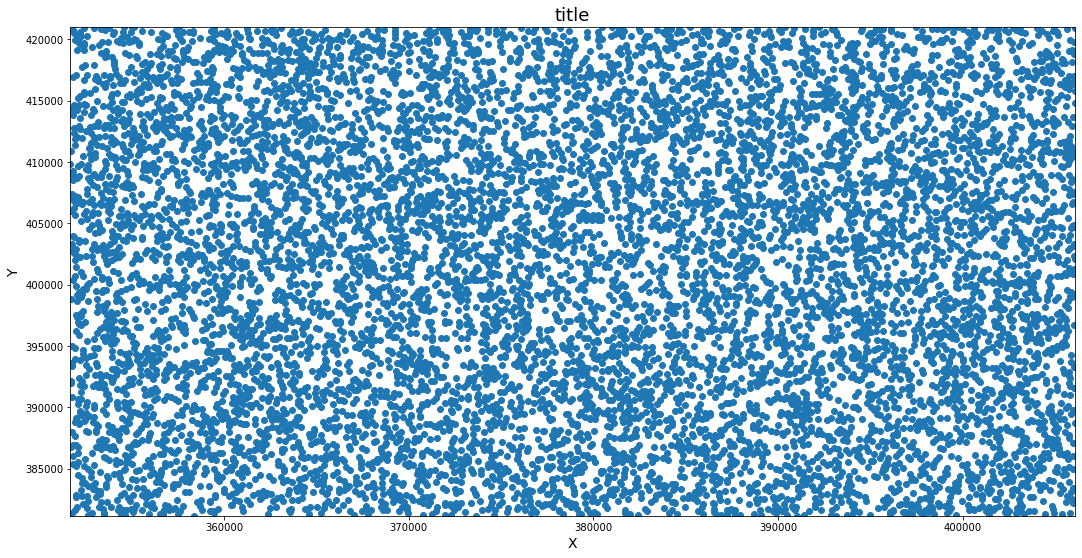

In [24]:
# generate random points (i.e. locations) 100 meters apart from each other using Euclidean distance
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

#prng = RandomState(1234567890)

points_100 = np.array([])       # x, y columnwise
while points_100.shape[0] < 10000:
    np.random.seed(42)
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_100) == 0:                # add first point blindly
        points_100 = np.array([p])
    elif distance(p, points_100, 100):     # ensure the minimum distance equal to buffer zone is met
        points_100 = np.vstack((points_100, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_100[:,0], points_100[:,1])

In [25]:
# convert np array to point geometry
x, y = np.split(points_100,[-1],axis=1) # split array into x and y
sample_100 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_100 = pd.DataFrame(sample_100, columns=['geometry'])
gdf_100 = gpd.GeoDataFrame(df_100, geometry='geometry', crs = 'epsg:27700')
gdf_100.head()                      


,geometry
0,POINT (362125.292 392055.034)
1,POINT (377971.171 402346.176)
2,POINT (364310.461 403435.100)
3,POINT (369566.841 406840.228)
4,POINT (354567.818 412168.416)


In [26]:
# save gpd to GeoJSON
gdf_100.to_file("thesis_project/output/points/sample_points_100.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.2. Random location sampling within the study area for a buffer zone of 300 m

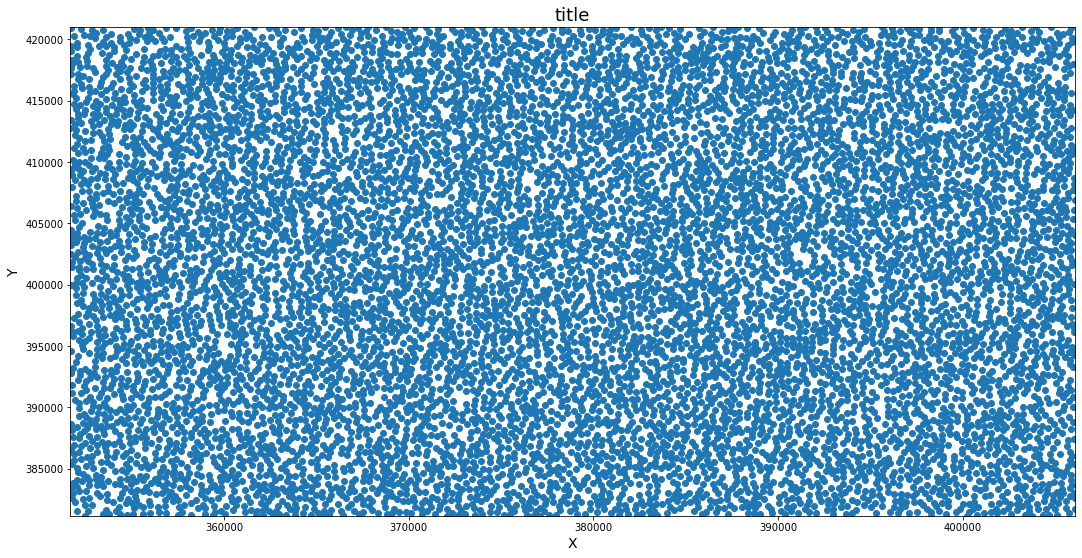

In [27]:
# generate random points (i.e. locations) 300 meters apart from each other using Euclidean distance
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_300 = np.array([])       # x, y columnwise
while points_300.shape[0] < 10000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_300) == 0:                # add first point blindly
        points_300 = np.array([p])
    elif distance(p, points_300, 300):     # ensure the minimum distance is met
        points_300 = np.vstack((points_300, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_300[:,0], points_300[:,1])

In [28]:
# convert np array to point geometry
x, y = np.split(points_300,[-1],axis=1) # split array into x and y
sample_300 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_300 = pd.DataFrame(sample_300, columns=['geometry'])
gdf_300 = gpd.GeoDataFrame(df_300, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_300.to_file("thesis_project/output/points/sample_points_300.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 1.4.3. Random location sampling within the study area for a buffer zone of 500 m

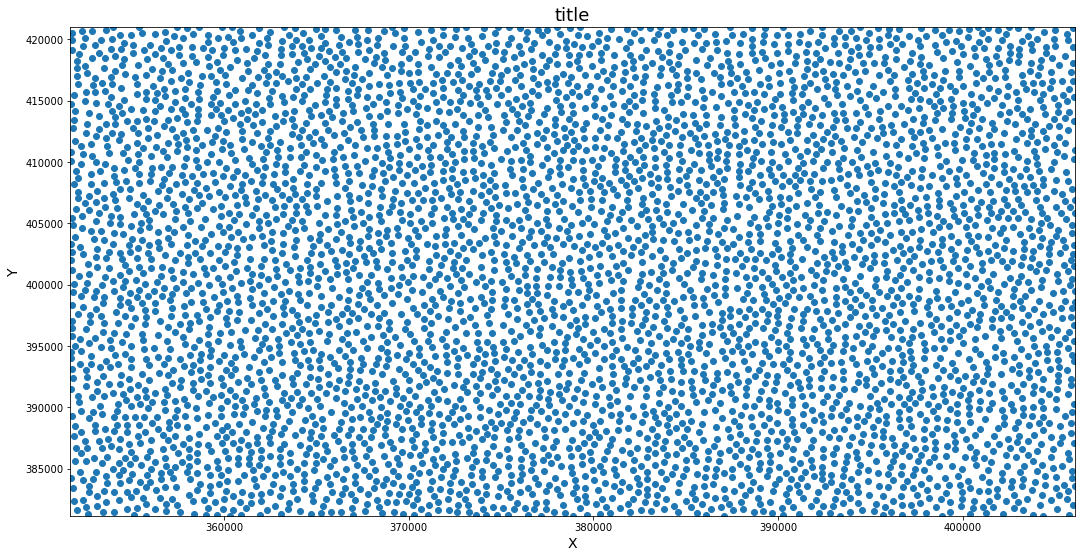

In [29]:
# generate random points (i.e. locations) 500 meters apart from each other using Euclidean distance
plt.close("all")

a = 406087.19669         # x bound
b = 421037.698468        # y bound

N = 10000        # number of points

def distance(p, points, min_distance):
    """
    Determines if any points in the list are less than the minimum specified 
    distance apart.

    Parameters
    ----------
    p : tuple
        `(x,y)` point.
    points : ndarray
        Array of points to check against. `x, y` points are columnwise.
    min_distance : float
        Minimum allowable distance between any two points.

    Returns
    -------
    bool
        True if point `p` is at least `min_distance` from all points in `points`.

    """
#    distances = np.sqrt(np.sum((p+points)**2, axis=1)) # generated points less than min distance
    distances = np.sqrt(np.sum(np.square(p-points), axis=1)) # added euclidean distance formula
    distances = np.where(distances < min_distance)
    return distances[0].size < 1

points_500 = np.array([])       # x, y columnwise
while points_500.shape[0] < 5000:
    x = random.choice(np.linspace(351662.603729, a, 100000))
    y = random.choice(np.linspace(381165.401794, b, 100000))
    p = (x,y)
    if len(points_500) == 0:                # add first point blindly
        points_500 = np.array([p])
    elif distance(p, points_500, 500):     # ensure the minimum distance is met
        points_500 = np.vstack((points_500, p))
        
fig = plt.figure(figsize=(18,9))
ax = plt.axes(projection=None)
ax.set_xlim([351662.603729, a])
ax.set_ylim([381165.401794, b])
ax.set_title('title',fontsize=18)
ax.set_xlabel('X',fontsize=14)
ax.set_ylabel('Y',fontsize=14)
ax.scatter(points_500[:,0], points_500[:,1])

In [30]:
# convert np array to point geometry
x, y = np.split(points_500,[-1],axis=1) # split array into x and y
points_500 = GeoSeries(map(Point, zip(x, y)))

# convert list of point geometries to geodataframe
df_500 = pd.DataFrame(points_500, columns=['geometry'])
gdf_500 = gpd.GeoDataFrame(df_500, geometry='geometry', crs = 'epsg:27700')

# save gpd to GeoJSON
gdf_500.to_file("thesis_project/output/points/sample_points_500.json", driver="GeoJSON")


/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# 1.5. Step 5: extraction of raster values

### 1.5.1. Extraction of NDVI values for a buffer zone of 100 m

In [31]:
# check point locations df
gdf_100.head()

,geometry
0,POINT (362125.292 392055.034)
1,POINT (377971.171 402346.176)
2,POINT (364310.461 403435.100)
3,POINT (369566.841 406840.228)
4,POINT (354567.818 412168.416)


In [32]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_100.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_100['point_coordinates'] = point_coords
gdf_100.head()

,geometry,point_coordinates
0,POINT (362125.292 392055.034),"(362125.2921067064, 392055.03363495454)"
1,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)"
2,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)"
3,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)"
4,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)"


In [33]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['NDVI_100'] = [x[0] for x in ndvi_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100
0,POINT (362125.292 392055.034),"(362125.2921067064, 392055.03363495454)",0.433062
1,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661
2,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632
3,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264
4,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594


### 1.5.2. Extraction of NDVI values for a buffer zone of 300 m

In [34]:
# check point locations df
gdf_300.head()

,geometry
0,POINT (396607.971 420663.294)
1,POINT (357230.295 401556.298)
2,POINT (390380.102 385914.240)
3,POINT (374281.691 415010.143)
4,POINT (389574.066 388155.085)


In [35]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_300.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_300['point_coordinates'] = point_coords
gdf_300.head()

,geometry,point_coordinates
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)"
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)"
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)"
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)"
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)"


In [36]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['NDVI_300'] = [x[0] for x in ndvi_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576


### 1.5.3. Extraction of NDVI values for a buffer zone of 500 m

In [37]:
# check point locations df
gdf_500.head()

,geometry
0,POINT (353361.757 416428.016)
1,POINT (402122.870 389757.170)
2,POINT (363560.483 384381.533)
3,POINT (377098.736 391409.893)
4,POINT (388776.738 395338.550)


In [38]:
# obtain point coordinates (x, y) from point geometry (x y) to later extract raster values
point_coords = []
for index, row in gdf_500.iterrows():
     for pt in list(row['geometry'].coords): 
        point_coords.append(pt)
#print(point_coords)

# add point coordinates to geodataframe
gdf_500['point_coordinates'] = point_coords
gdf_500.head()

,geometry,point_coordinates
0,POINT (353361.757 416428.016),"(353361.75651277025, 416428.0161526957)"
1,POINT (402122.870 389757.170),"(402122.8696954508, 389757.1701989976)"
2,POINT (363560.483 384381.533),"(363560.4829749967, 384381.533405041)"
3,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)"
4,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)"


In [39]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['NDVI_500'] = [x[0] for x in ndvi_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500
0,POINT (353361.757 416428.016),"(353361.75651277025, 416428.0161526957)",0.696964
1,POINT (402122.870 389757.170),"(402122.8696954508, 389757.1701989976)",0.618661
2,POINT (363560.483 384381.533),"(363560.4829749967, 384381.533405041)",0.447487
3,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847
4,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095


# 2. All green spaces

## 2.1. Step 1: processing green spaces input image

In [40]:
# data dir
data_dir = r"thesis_project/data"
fp_green = os.path.join(data_dir, "GreenNoGreenRes.TIF")

# open the file
green_input_raster = rasterio.open(fp_green)

# check type of the variable 'raster'
type(green_input_raster)

rasterio.io.DatasetReader

In [41]:
# check metadata for the whole raster dataset
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

In [42]:
# read the raster band as separate variable
green_input = green_input_raster.read(1)
#type(green_input)
green_input

array([[1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]], dtype=uint8)

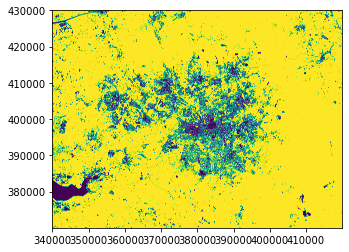

<AxesSubplot:>

In [43]:
# plot Greenspace input
show(green_input_raster, 1)

## 2.2. Step 2: focal statistics analysis

### 2.2.1.Focal statistics analysis for a buffer zone of 100 meters

In [44]:
# design kernel for a buffer zone of 100 m (r = 41 for 5 x 5 m resolution)
green_filter_100 = np.ones((41, 41))
green_filter_100.shape

(41, 41)

In [45]:
# convolve filter (i.e. buffer zone) over the whole Greenspace image using FFT and average NDVI values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
green_output_100 = fftconvolve(green_input, green_filter_100, mode = "same") / np.sum(green_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_100.shape

--- 22.21667504310608 seconds ---


(12000, 16000)

### 2.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [46]:
# design kernel for a buffer zone of 300 m (r = 121 for 5 x 5 m resolution)
green_filter_300 = np.ones((121, 121))
green_filter_300.shape

(121, 121)

In [47]:
# convolve filter (i.e. buffer zone) over the whole Greenspace image using FFT and average NDVI values. 
start_time = time.time()
green_output_300 = fftconvolve(green_input, green_filter_300, mode = "same") / np.sum(green_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_300.shape

--- 39.9282660484314 seconds ---


(12000, 16000)

### 2.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [48]:
# design kernel for a buffer zone of 500 m (r = 201 for 5 x 5 m resolution)
green_filter_500 = np.ones((201, 201))
green_filter_500.shape

(201, 201)

In [49]:
# convolve filter (i.e. buffer zone) over the whole Greenspace image using FFT and average NDVI values.
start_time = time.time()
green_output_500 = fftconvolve(green_input, green_filter_500, mode = "same") / np.sum(green_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
green_output_500.shape

--- 26.349340200424194 seconds ---


(12000, 16000)

## 2.3. Step 3: development of Greenspace% exposure maps

In [50]:
# Greenspace input image boundaries
green_input_raster.bounds

BoundingBox(left=339999.2458, bottom=370003.9122, right=419999.2458, top=430003.9122)

In [51]:
# check raster metadata
green_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': 255.0,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.1. Greenspace% map capturing exposure for a buffer zone of 100 m

In [52]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_100.tif', 'w', driver='GTiff',
                            height = green_output_100.shape[0], width = green_output_100.shape[1],
                            count=1, dtype=str(green_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_100, 1)
new_dataset.close()

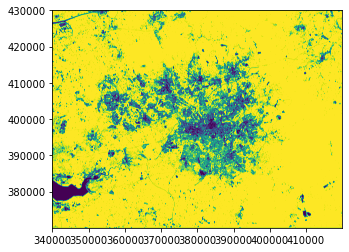

--- 21.05833387374878 seconds ---


In [53]:
# Greenspace% exposure map at 100 m
start_time = time.time()
green_src_100 = rasterio.open("thesis_project/output/layers/green_output_100.tif")
show(green_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [54]:
# output layer metadata
green_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.2. Greenspace% map capturing exposure for a buffer zone of 300 m

In [55]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_300.tif', 'w', driver='GTiff',
                            height = green_output_300.shape[0], width = green_output_300.shape[1],
                            count=1, dtype=str(green_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_300, 1)
new_dataset.close()

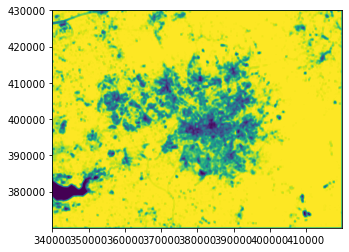

--- 17.34183692932129 seconds ---


In [56]:
# Greenspace% exposure map 300 m
start_time = time.time()
green_src_300 = rasterio.open("thesis_project/output/layers/green_output_300.tif")
show(green_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [57]:
# output layer metadata
green_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### 2.3.3. Greenspace% map capturing exposure for a buffer zone of 500 m

In [58]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(339999.2458, 430003.9122, 5.0, 5.0) #output (top-left)


new_dataset = rasterio.open('thesis_project/output/layers/green_output_500.tif', 'w', driver='GTiff',
                            height = green_output_500.shape[0], width = green_output_500.shape[1],
                            count=1, dtype=str(green_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(green_output_500, 1)
new_dataset.close()

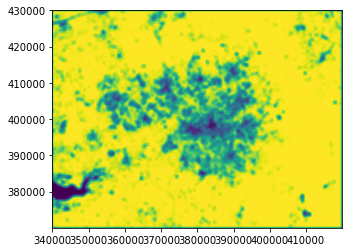

--- 21.685697078704834 seconds ---


In [59]:
# Greenspace% exposure map at 500 m
start_time = time.time()
green_src_500 = rasterio.open("thesis_project/output/layers/green_output_500.tif")
show(green_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [60]:
# output layer metadata
green_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 16000,
 'height': 12000,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(5.0, 0.0, 339999.2458,
        0.0, -5.0, 430003.9122)}

### Step 4: random location sampling within the Greater Manchester area is no longer required as the data frame used only contains locations that satisfy step 4.

## 2.4. Step 5: extraction of raster values

### 2.4.1. Extraction of Greenspace% values for a buffer zone of 100 m

In [61]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Greenspace%_100'] = [x[0] for x in green_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (362125.292 392055.034),"(362125.2921067064, 392055.03363495454)",0.433062,0.845330
1,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039
2,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457
3,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395
4,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891


In [62]:
# check if null values in gdf
gdf_100.isnull().values.any()

False

### 2.4.2. Extraction of Greenspace% values for a buffer zone of 300 m

In [63]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Greenspace%_300'] = [x[0] for x in green_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616


In [64]:
# check if null values in gdf
gdf_300.isnull().values.any()

False

### 2.4.3. Extraction of Greenspace% values for a buffer zone of 500 m

In [65]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Greenspace%_500'] = [x[0] for x in green_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (353361.757 416428.016),"(353361.75651277025, 416428.0161526957)",0.696964,0.986733
1,POINT (402122.870 389757.170),"(402122.8696954508, 389757.1701989976)",0.618661,0.998614
2,POINT (363560.483 384381.533),"(363560.4829749967, 384381.533405041)",0.447487,0.998886
3,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710
4,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368


In [66]:
# check if null values in gdf
gdf_500.isnull().values.any()

False

# 3. Tree canopy

## 3.1. Step 1: processing Tree canopy input image

In [3]:
# data dir
data_dir = r"thesis_project/data"
fp_tree = os.path.join(data_dir, "Tree_no_Tree_10m.TIF")

# open the file
tree_input_raster = rasterio.open(fp_tree)

# check type of the variable 'raster'
type(tree_input_raster)

rasterio.io.DatasetReader

In [4]:
# check metadata for the whole raster dataset
tree_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [4]:
# read the raster band as separate variable
tree_input = tree_input_raster.read(1)
#tree_input
type(tree_input)


numpy.ndarray

In [5]:
# convert array to uint8
tree_input = tree_input.astype(np.uint8)
tree_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

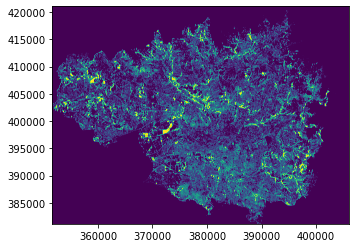

<AxesSubplot:>

In [71]:
# plot Tree canopy input image
show(tree_input_raster, 1)

## 3.2. Step 2: focal statistics analysis

### 3.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [72]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
canopy_filter_100 = np.ones((21, 21))
canopy_filter_100.shape

(21, 21)

In [73]:
# convolve filter (i.e. buffer zone) over the whole Tree canopy image using FFT and average NDVI values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
canopy_output_100 = fftconvolve(tree_input, canopy_filter_100, mode = "same") / np.sum(canopy_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_100.shape

--- 2.1175389289855957 seconds ---


(3987, 5441)

### 3.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [6]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
canopy_filter_300 = np.ones((61, 61))
canopy_filter_300.shape

(61, 61)

In [7]:
# convolve filter (i.e. buffer zone) over the whole Tree canopy image using FFT and average NDVI values.
start_time = time.time()
canopy_output_300 = fftconvolve(tree_input, canopy_filter_300, mode = "same") / np.sum(canopy_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_300.shape

--- 1.9961521625518799 seconds ---


(3987, 5441)

### 3.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [76]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
canopy_filter_500 = np.ones((101, 101))
canopy_filter_500.shape

(101, 101)

In [77]:
# convolve filter (i.e. buffer zone) over the whole Tree canopy image using FFT and average NDVI values.
start_time = time.time()
canopy_output_500 = fftconvolve(tree_input, canopy_filter_500, mode = "same") / np.sum(canopy_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
canopy_output_500.shape

--- 1.993246078491211 seconds ---


(3987, 5441)

## 3.3. Step 3: development of Canopy% exposure maps

In [78]:
# checking bounds
tree_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 3.3.1. Canopy% map capturing exposure for a buffer zone of 100 m

In [79]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_100.tif', 'w', driver='GTiff',
                            height = canopy_output_100.shape[0], width = canopy_output_100.shape[1],
                            count=1, dtype=str(canopy_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_100, 1)
new_dataset.close()

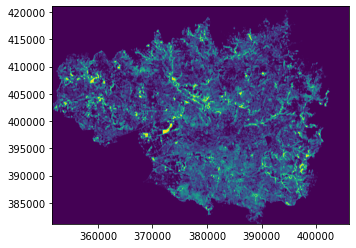

--- 1.4405958652496338 seconds ---


In [80]:
# Canopy% exposure map at 100 m
start_time = time.time()
canopy_src_100 = rasterio.open("thesis_project/output/layers/canopy_output_100.tif")
show(canopy_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [81]:
# output layer metadata
canopy_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 3.3.2. Canopy% map capturing exposure for a buffer zone of 300 m

In [8]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_300.tif', 'w', driver='GTiff',
                            height = canopy_output_300.shape[0], width = canopy_output_300.shape[1],
                            count=1, dtype=str(canopy_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_300, 1)
new_dataset.close()

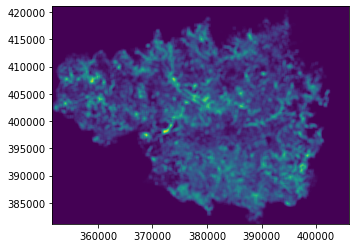

--- 1.366407871246338 seconds ---


In [83]:
# Canopy% exposure map at 300 m
start_time = time.time()
canopy_src_300 = rasterio.open("thesis_project/output/layers/canopy_output_300.tif")
show(canopy_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# output layer metadata
canopy_src_300.meta

### 3.3.3. Canopy% map capturing exposure for a buffer zone of 500 m

In [84]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (top-left)

new_dataset = rasterio.open('thesis_project/output/layers/canopy_output_500.tif', 'w', driver='GTiff',
                            height = canopy_output_500.shape[0], width = canopy_output_500.shape[1],
                            count=1, dtype=str(canopy_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(canopy_output_500, 1)
new_dataset.close()

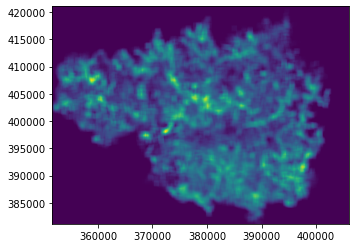

--- 1.4126358032226562 seconds ---


In [85]:
# Canopy% exposure map at 500 m
start_time = time.time()
canopy_src_500 = rasterio.open("thesis_project/output/layers/canopy_output_500.tif")
show(canopy_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [ ]:
# output layer metadata
canopy_src_500.meta

## 3.4. Step 5: extraction of raster values

In [86]:
# read Geopackage containing GM boundary
gm_boundaries = gpd.read_file("thesis_project/data/GM_Boundary.gpkg")
gm_boundaries.head()

,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,geometry
0,1,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,"MULTIPOLYGON (((406087.197 404640.102, 406041...."


<AxesSubplot:>

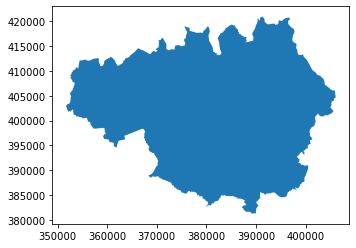

In [87]:
# plot GM boundary
gm_boundaries.plot()

### 3.4.1. Extraction of Canopy% values for a buffer zone of 100 m

In [88]:
# check gdf
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100
0,POINT (362125.292 392055.034),"(362125.2921067064, 392055.03363495454)",0.433062,0.845330
1,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039
2,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457
3,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395
4,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891


In [89]:
# join greenspace metrics and GM boundaries
gdf_100_full = sjoin(gdf_100, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_100 = gdf_100_full[gdf_100_full['index_right'].notna()].reset_index(drop=True)
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (388526.382 403175.927),"(388526.38191705605, 403175.9271092346)",0.285577,0.388459,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [90]:
# check how many points within GM with all metrics
len(gdf_100)

5842

In [91]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Canopy%_100'] = [x[0] for x in canopy_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100
0,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.201814
1,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.108844
2,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.129252
3,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.009070
4,POINT (388526.382 403175.927),"(388526.38191705605, 403175.9271092346)",0.285577,0.388459,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.217687


### 3.4.2. Extraction of Canopy% values for a buffer zone of 300 m

In [92]:
# check gdf
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616


In [93]:
# join greenspace metrics and GM boundaries
gdf_300_full = sjoin(gdf_300, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_300 = gdf_300_full[gdf_300_full['index_right'].notna()].reset_index(drop=True)
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [94]:
# check how many points within GM with all metrics
len(gdf_300)

5860

In [95]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Canopy%_300'] = [x[0] for x in canopy_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.191389e-17
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.050524e-01
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.829616e-01
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,4.407417e-02
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.039506e-01


### 3.4.3. Extraction of Canopy% values for a buffer zone of 500 m

In [96]:
# check gdf
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500
0,POINT (353361.757 416428.016),"(353361.75651277025, 416428.0161526957)",0.696964,0.986733
1,POINT (402122.870 389757.170),"(402122.8696954508, 389757.1701989976)",0.618661,0.998614
2,POINT (363560.483 384381.533),"(363560.4829749967, 384381.533405041)",0.447487,0.998886
3,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710
4,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368


In [97]:
# join greenspace metrics and GM boundaries
gdf_500_full = sjoin(gdf_500, gm_boundaries, how='left')

# take rows where 'index_right' is not NaN
gdf_500 = gdf_500_full[gdf_500_full['index_right'].notna()].reset_index(drop=True)
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2
0,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
1,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
2,POINT (385102.497 389586.914),"(385102.4965350257, 389586.9137896355)",0.465877,0.683176,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
3,POINT (358860.328 409008.505),"(358860.3281253362, 409008.50499248615)",0.632368,0.961635,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98
4,POINT (369877.609 414278.479),"(369877.60865123675, 414278.47914363025)",0.622829,0.985297,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98


In [98]:
# check how many points within GM with all metrics
len(gdf_500)

2898

In [99]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Canopy%_500'] = [x[0] for x in canopy_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500
0,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.345652
1,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.184884
2,POINT (385102.497 389586.914),"(385102.4965350257, 389586.9137896355)",0.465877,0.683176,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.310852
3,POINT (358860.328 409008.505),"(358860.3281253362, 409008.50499248615)",0.632368,0.961635,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.132144
4,POINT (369877.609 414278.479),"(369877.60865123675, 414278.47914363025)",0.622829,0.985297,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.122635


# 4. Grass density

## 4.1. Step 1: processing Grass density input image

In [100]:
# data dir
data_dir = r"thesis_project/data"
fp_grass = os.path.join(data_dir, "Grass_no_grass_10m.TIF")

# open the file
grass_input_raster = rasterio.open(fp_grass)

# check type of the variable 'raster'
type(grass_input_raster)

rasterio.io.DatasetReader

In [101]:
# check metadata for the whole raster dataset
grass_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': -3.4028234663852886e+38,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [102]:
# read the raster band as separate variable
grass_input = grass_input_raster.read(1)
#grass_input
type(grass_input)

numpy.ndarray

In [103]:
# convert array to uint8
grass_input = grass_input.astype(np.uint8)
grass_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

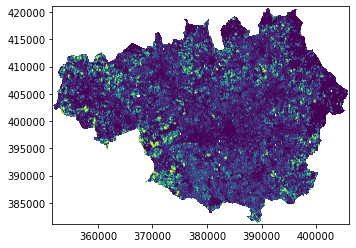

<AxesSubplot:>

In [104]:
# plot Grass density input image
show(grass_input_raster, 1)

## 4.2. Step 2: focal statistics analysis

### 4.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [105]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
grass_filter_100 = np.ones((21, 21))
grass_filter_100.shape

(21, 21)

In [106]:
# convolve filter (i.e. buffer zone) over the whole Grass density image using FFT and average Grass density values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
grass_output_100 = fftconvolve(grass_input, grass_filter_100, mode = "same") / np.sum(grass_filter_100) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_100.shape

--- 2.4083969593048096 seconds ---


(3987, 5441)

### 4.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [107]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
grass_filter_300 = np.ones((61, 61))
grass_filter_300.shape

(61, 61)

In [108]:
# convolve filter (i.e. buffer zone) over the whole Grass density image using FFT and average Grass density values. 
start_time = time.time()
grass_output_300 = fftconvolve(grass_input, grass_filter_300, mode = "same") / np.sum(grass_filter_300) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_300.shape

--- 1.6076669692993164 seconds ---


(3987, 5441)

### 4.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [9]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
grass_filter_500 = np.ones((101, 101))
grass_filter_500.shape

(101, 101)

In [110]:
# convolve filter (i.e. buffer zone) over the whole Grass density image using FFT and average Grass density values.
start_time = time.time()
grass_output_500 = fftconvolve(grass_input, grass_filter_500, mode = "same") / np.sum(grass_filter_500) # mode=reflect to extend input beyond its boundaries
print("--- %s seconds ---" % (time.time() - start_time))
grass_output_500.shape

--- 1.6636991500854492 seconds ---


(3987, 5441)

## 4.3. Step 3: development of Grass% exposure maps

In [111]:
# checking bounds
grass_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 4.3.1. Grass% map capturing exposure for a buffer zone of 100 m

In [112]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_100.tif', 'w', driver='GTiff',
                            height = grass_output_100.shape[0], width = grass_output_100.shape[1],
                            count=1, dtype=str(grass_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_100, 1)
new_dataset.close()

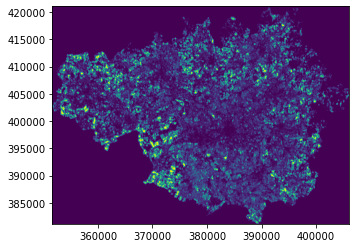

--- 1.6735429763793945 seconds ---


In [113]:
# Grass% exposure map at 100 m
start_time = time.time()
grass_src_100 = rasterio.open("thesis_project/output/layers/grass_output_100.tif")
show(grass_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [114]:
# output layer metadata
grass_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 4.3.2. Grass% map capturing exposure for a buffer zone of 300 m

In [115]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_300.tif', 'w', driver='GTiff',
                            height = grass_output_300.shape[0], width = grass_output_300.shape[1],
                            count=1, dtype=str(grass_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_300, 1)
new_dataset.close()

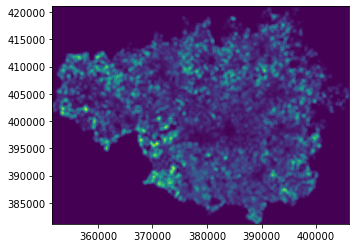

--- 1.7834298610687256 seconds ---


In [116]:
# Grass% exposure map at 300 m
start_time = time.time()
grass_src_300 = rasterio.open("thesis_project/output/layers/grass_output_300.tif")
show(grass_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [117]:
# output layer metadata
grass_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 4.3.3. Grass% map capturing exposure for a buffer zone of 500 m

In [118]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/grass_output_500.tif', 'w', driver='GTiff',
                            height = grass_output_500.shape[0], width = grass_output_500.shape[1],
                            count=1, dtype=str(grass_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(grass_output_500, 1)
new_dataset.close()

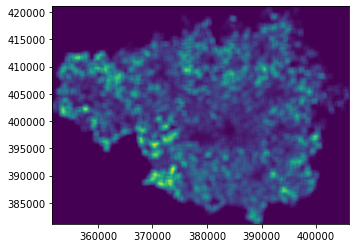

--- 1.4469618797302246 seconds ---


In [119]:
# Grass% exposure map at 500 m
start_time = time.time()
grass_src_500 = rasterio.open("thesis_project/output/layers/grass_output_500.tif")
show(grass_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [120]:
# output layer metadata
grass_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 4.4. Step 5: extraction of raster values

### 4.4.1. Extraction of Grass% values for a buffer zone of 100 m

In [121]:
# check greenspace metrics df
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100
0,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.201814
1,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.108844
2,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.129252
3,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.009070
4,POINT (388526.382 403175.927),"(388526.38191705605, 403175.9271092346)",0.285577,0.388459,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.217687


In [122]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Grass%_100'] = [x[0] for x in grass_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100
0,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.201814,0.097506
1,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.108844,0.072562
2,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.129252,0.092971
3,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.009070,0.249433
4,POINT (388526.382 403175.927),"(388526.38191705605, 403175.9271092346)",0.285577,0.388459,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.217687,0.061224


### 4.4.2. Extraction of Grass% values for a buffer zone of 300 m

In [123]:
# check greenspace metrics df
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.191389e-17
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.050524e-01
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.829616e-01
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,4.407417e-02
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.039506e-01


In [124]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Grass%_300'] = [x[0] for x in grass_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.191389e-17,0.049718
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.050524e-01,0.102392
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.829616e-01,0.197796
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,4.407417e-02,0.148347
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.039506e-01,0.133835


### 4.4.3. Extraction of Grass% values for a buffer zone of 500 m

In [125]:
# check greenspace metrics df
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500
0,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.345652
1,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.184884
2,POINT (385102.497 389586.914),"(385102.4965350257, 389586.9137896355)",0.465877,0.683176,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.310852
3,POINT (358860.328 409008.505),"(358860.3281253362, 409008.50499248615)",0.632368,0.961635,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.132144
4,POINT (369877.609 414278.479),"(369877.60865123675, 414278.47914363025)",0.622829,0.985297,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.122635


In [126]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Grass%_500'] = [x[0] for x in grass_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500
0,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.345652,0.204588
1,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.184884,0.114106
2,POINT (385102.497 389586.914),"(385102.4965350257, 389586.9137896355)",0.465877,0.683176,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.310852,0.177532
3,POINT (358860.328 409008.505),"(358860.3281253362, 409008.50499248615)",0.632368,0.961635,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.132144,0.427213
4,POINT (369877.609 414278.479),"(369877.60865123675, 414278.47914363025)",0.622829,0.985297,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.122635,0.113910


# 5. Forbs and shrubs density

## 5.1. Step 1: processing forbs and shurbs density input image

In [127]:
# data dir
data_dir = r"thesis_project/data"
fp_shrubs = os.path.join(data_dir, "Shrubs_no_shrubs_10m.TIF")

# open the file
shrubs_input_raster = rasterio.open(fp_shrubs)

# check type of the variable 'raster'
type(shrubs_input_raster)

rasterio.io.DatasetReader

In [128]:
# check metadata for the whole raster dataset
shrubs_input_raster.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

In [129]:
# read the raster band as separate variable
shrubs_input = shrubs_input_raster.read(1)
#shrubs_input
type(shrubs_input)

numpy.ndarray

In [130]:
# convert array to uint8
shrubs_input = shrubs_input.astype(np.uint8)
shrubs_input

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

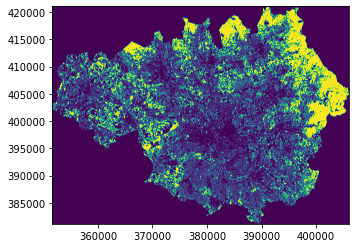

<AxesSubplot:>

In [131]:
# plot input map
show(shrubs_input_raster, 1)

## 5.2. Step 2: focal statistics analysis

### 5.2.1. Focal statistics analysis for a buffer zone of 100 meters

In [132]:
# design kernel for a buffer zone of 100 m (r = 21 for 10 x 10 m resolution)
shrubs_filter_100 = np.ones((21, 21))
shrubs_filter_100.shape

(21, 21)

In [133]:
# convolve filter (i.e. buffer zone) over the whole shrubs density image using FFT and average shrubs density values. 
# if mode = "same", the output size will equal the size of the input. Convolution assumes zero-padding boundaries.
start_time = time.time()
shrubs_output_100 = fftconvolve(shrubs_input, shrubs_filter_100, mode = "same") / np.sum(shrubs_filter_100)
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_100.shape

--- 2.0365827083587646 seconds ---


(3987, 5441)

### 5.2.2. Focal statistics analysis for a buffer zone of 300 meters

In [134]:
# design kernel for a buffer zone of 300 m (r = 61 for 10 x 10 m resolution)
shrubs_filter_300 = np.ones((61, 61))
shrubs_filter_300.shape

(61, 61)

In [135]:
# convolve filter (i.e. buffer zone) over the whole shrubs density image using FFT and average shrubs density values.
start_time = time.time()
shrubs_output_300 = fftconvolve(shrubs_input, shrubs_filter_300, mode = "same") / np.sum(shrubs_filter_300)
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_300.shape

--- 1.7219009399414062 seconds ---


(3987, 5441)

### 5.2.3. Focal statistics analysis for a buffer zone of 500 meters

In [136]:
# design kernel for a buffer zone of 500 m (r = 101 for 10 x 10 m resolution)
shrubs_filter_500 = np.ones((101, 101))
shrubs_filter_500.shape

(101, 101)

In [137]:
# convolve filter (i.e. buffer zone) over the whole shrubs density image using FFT and average shrubs density values.
start_time = time.time()
shrubs_output_500 = fftconvolve(shrubs_input, shrubs_filter_500, mode = "same") / np.sum(shrubs_filter_500)
print("--- %s seconds ---" % (time.time() - start_time))
shrubs_output_500.shape

--- 1.7714319229125977 seconds ---


(3987, 5441)

## 5.3. Step 3: development of Shrubs% exposure maps

In [138]:
# checking bounds
shrubs_input_raster.bounds

BoundingBox(left=351662.35, bottom=381166.0433, right=406072.35, top=421036.0433)

### 5.3.1. Shrubs% map capturing exposure for a buffer zone of 100 m

In [139]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_100.tif', 'w', driver='GTiff',
                            height = shrubs_output_100.shape[0], width = shrubs_output_100.shape[1],
                            count=1, dtype=str(shrubs_output_100.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_100, 1)
new_dataset.close()

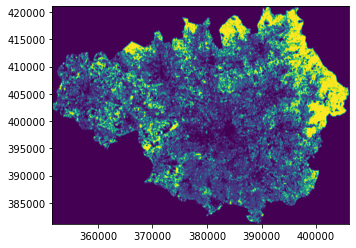

--- 1.9772942066192627 seconds ---


In [140]:
# Shrubs% exposure map at 100 m
start_time = time.time()
shrubs_src_100 = rasterio.open("thesis_project/output/layers/shrubs_output_100.tif")
show(shrubs_src_100, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [141]:
# output layer metadata
shrubs_src_100.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 5.3.2. Shrubs% map capturing exposure for a buffer zone of 300 m

In [142]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_300.tif', 'w', driver='GTiff',
                            height = shrubs_output_300.shape[0], width = shrubs_output_300.shape[1],
                            count=1, dtype=str(shrubs_output_300.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_300, 1)
new_dataset.close()

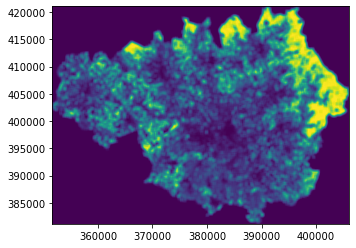

--- 1.8898909091949463 seconds ---


In [143]:
# Shrubs% exposure map at 300 m
start_time = time.time()
shrubs_src_300 = rasterio.open("thesis_project/output/layers/shrubs_output_300.tif")
show(shrubs_src_300, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [144]:
# output layer metadata
shrubs_src_300.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

### 5.3.3. Shrubs% map capturing exposure for a buffer zone of 500 m

In [145]:
# convert output of focal statistics analysis to exposure map/ raster image
transform = from_origin(351662.35, 421036.0433, 10.0, 10.0) #output (left-top)


new_dataset = rasterio.open('thesis_project/output/layers/shrubs_output_500.tif', 'w', driver='GTiff',
                            height = shrubs_output_500.shape[0], width = shrubs_output_500.shape[1],
                            count=1, dtype=str(shrubs_output_500.dtype),
                            crs='+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=400000 +y_0=-100000 +ellps=airy +towgs84=446.448,-125.157,542.06,0.15,0.247,0.842,-20.489 +units=m +no_defs',
                            transform=transform)

new_dataset.write(shrubs_output_500, 1)
new_dataset.close()

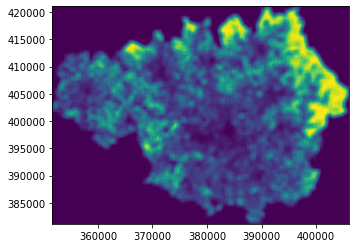

--- 2.514285087585449 seconds ---


In [146]:
# Shrubs% exposure map at 500 m
start_time = time.time()
shrubs_src_500 = rasterio.open("thesis_project/output/layers/shrubs_output_500.tif")
show(shrubs_src_500, 1)
print("--- %s seconds ---" % (time.time() - start_time))

In [147]:
# output layer metadata
shrubs_src_500.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 5441,
 'height': 3987,
 'count': 1,
 'crs': CRS.from_epsg(27700),
 'transform': Affine(10.0, 0.0, 351662.35,
        0.0, -10.0, 421036.0433)}

## 5.4. Step 5: extraction of raster values

### 5.4.1. Extraction of Shrubs% values for a buffer zone of 100 m

In [148]:
# check greenspace metrics df
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100
0,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.201814,0.097506
1,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.108844,0.072562
2,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.129252,0.092971
3,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.009070,0.249433
4,POINT (388526.382 403175.927),"(388526.38191705605, 403175.9271092346)",0.285577,0.388459,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.217687,0.061224


In [149]:
# sample the raster at every point location and store values in Geodataframe
gdf_100['Shrubs%_100'] = [x[0] for x in shrubs_src_100.sample(gdf_100.point_coordinates)]
gdf_100.head()

,geometry,point_coordinates,NDVI_100,Greenspace%_100,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_100,Grass%_100,Shrubs%_100
0,POINT (377971.171 402346.176),"(377971.1708060886, 402346.17631794076)",0.295661,0.414039,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.201814,0.097506,0.106576
1,POINT (364310.461 403435.100),"(364310.4613657832, 403435.0996293408)",0.333632,0.551457,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.108844,0.072562,0.340136
2,POINT (369566.841 406840.228),"(369566.84111775405, 406840.2278165823)",0.209264,0.256395,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.129252,0.092971,0.043084
3,POINT (354567.818 412168.416),"(354567.81755339645, 412168.4161030118)",0.594594,0.942891,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.009070,0.249433,0.068027
4,POINT (388526.382 403175.927),"(388526.38191705605, 403175.9271092346)",0.285577,0.388459,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.217687,0.061224,0.111111


In [150]:
# check how many points within GM with all metrics
len(gdf_100)

5842

In [151]:
# keep target columns
gdf_100 = gdf_100[['NDVI_100', 'Greenspace%_100', 'Canopy%_100', 'Grass%_100', 'Shrubs%_100', 'geometry']]

# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_100','Greenspace%_100', 'Canopy%_100', 'Grass%_100', 'Shrubs%_100']
gdf_100[cols_to_norm] = gdf_100[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_100.head()

,NDVI_100,Greenspace%_100,Canopy%_100,Grass%_100,Shrubs%_100,geometry
0,0.536433,0.414039,0.201814,0.097506,0.106576,POINT (377971.171 402346.176)
1,0.571965,0.551457,0.108844,0.072562,0.340136,POINT (364310.461 403435.100)
2,0.455587,0.256395,0.129252,0.092971,0.043084,POINT (369566.841 406840.228)
3,0.816160,0.942891,0.009070,0.249433,0.068027,POINT (354567.818 412168.416)
4,0.526997,0.388459,0.217687,0.061224,0.111111,POINT (388526.382 403175.927)


In [152]:
# save geodataframe to geojson
gdf_100.to_file("thesis_project/output/dataframes/greenspace_metrics_100_df.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.4.2. Extraction of Shrubs% values for a buffer zone of 300 m

In [153]:
# check greenspace metrics df
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.191389e-17,0.049718
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.050524e-01,0.102392
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.829616e-01,0.197796
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,4.407417e-02,0.148347
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.039506e-01,0.133835


In [154]:
# sample the raster at every point location and store values in Geodataframe
gdf_300['Shrubs%_300'] = [x[0] for x in shrubs_src_300.sample(gdf_300.point_coordinates)]
gdf_300.head()

,geometry,point_coordinates,NDVI_300,Greenspace%_300,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_300,Grass%_300,Shrubs%_300
0,POINT (396607.971 420663.294),"(396607.97054172115, 420663.29385818506)",0.361488,0.956970,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,-2.191389e-17,0.049718,0.421661
1,POINT (357230.295 401556.298),"(357230.2952658257, 401556.29822204786)",0.396348,0.509391,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,2.050524e-01,0.102392,0.198603
2,POINT (390380.102 385914.240),"(390380.10209050943, 385914.2398162536)",0.620308,0.933748,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.829616e-01,0.197796,0.354206
3,POINT (374281.691 415010.143),"(374281.69075446186, 415010.1431042378)",0.729573,0.990028,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,4.407417e-02,0.148347,0.605482
4,POINT (389574.066 388155.085),"(389574.06580839417, 388155.0852977872)",0.420576,0.585616,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,3.039506e-01,0.133835,0.148616


In [155]:
# check how many points within GM with all metrics
len(gdf_300)

5860

In [156]:
# keep target columns
gdf_300 = gdf_300[['NDVI_300', 'Greenspace%_300', 'Canopy%_300', 'Grass%_300', 'Shrubs%_300', 'geometry']]

# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_300', 'Greenspace%_300', 'Canopy%_300', 'Grass%_300', 'Shrubs%_300']
gdf_300[cols_to_norm] = gdf_300[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_300.head()

,NDVI_300,Greenspace%_300,Canopy%_300,Grass%_300,Shrubs%_300,geometry
0,0.488255,0.955836,2.242873e-16,0.062290,0.421350,POINT (396607.971 420663.294)
1,0.531893,0.496460,2.145669e-01,0.128283,0.198172,POINT (357230.295 401556.298)
2,0.812246,0.932001,4.007312e-01,0.247811,0.353859,POINT (390380.102 385914.240)
3,0.949025,0.989765,4.611924e-02,0.185859,0.605270,POINT (374281.691 415010.143)
4,0.562222,0.574693,3.180540e-01,0.167677,0.148158,POINT (389574.066 388155.085)


In [157]:
# save geodataframe to geojson
gdf_300.to_file("thesis_project/output/dataframes/greenspace_metrics_300_df.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### 5.4.3. Extraction of Shrubs% values for a buffer zone of 500 m

In [158]:
# check greenspace metrics df
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500
0,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.345652,0.204588
1,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.184884,0.114106
2,POINT (385102.497 389586.914),"(385102.4965350257, 389586.9137896355)",0.465877,0.683176,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.310852,0.177532
3,POINT (358860.328 409008.505),"(358860.3281253362, 409008.50499248615)",0.632368,0.961635,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.132144,0.427213
4,POINT (369877.609 414278.479),"(369877.60865123675, 414278.47914363025)",0.622829,0.985297,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.122635,0.113910


In [159]:
# sample the raster at every point location and store values in Geodataframe
gdf_500['Shrubs%_500'] = [x[0] for x in shrubs_src_500.sample(gdf_500.point_coordinates)]
gdf_500.head()

,geometry,point_coordinates,NDVI_500,Greenspace%_500,index_right,OBJECTID,NAME,DESCRIPTIO,Shape_Leng,Shape_Area,area_Km2,Canopy%_500,Grass%_500,Shrubs%_500
0,POINT (377098.736 391409.893),"(377098.73585657426, 391409.8934233671)",0.459847,0.729710,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.345652,0.204588,0.179492
1,POINT (388776.738 395338.550),"(388776.73754823295, 395338.5501012231)",0.404095,0.544368,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.184884,0.114106,0.246152
2,POINT (385102.497 389586.914),"(385102.4965350257, 389586.9137896355)",0.465877,0.683176,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.310852,0.177532,0.196745
3,POINT (358860.328 409008.505),"(358860.3281253362, 409008.50499248615)",0.632368,0.961635,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.132144,0.427213,0.402313
4,POINT (369877.609 414278.479),"(369877.60865123675, 414278.47914363025)",0.622829,0.985297,0.0,1.0,Greater Manchester,Ceremonial County,248706.036033,1.275981e+09,1275.98,0.122635,0.113910,0.215273


In [160]:
# check how many points within GM with all metrics
len(gdf_500)

2898

In [161]:
# keep target columns
gdf_500 = gdf_500[['NDVI_500', 'Greenspace%_500', 'Canopy%_500', 'Grass%_500', 'Shrubs%_500', 'geometry']]

# normalize continuous variables (min-max)
cols_to_norm = ['NDVI_500', 'Greenspace%_500', 'Canopy%_500', 'Grass%_500', 'Shrubs%_500']
gdf_500[cols_to_norm] = gdf_500[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
gdf_500.head()

,NDVI_500,Greenspace%_500,Canopy%_500,Grass%_500,Shrubs%_500,geometry
0,0.616906,0.714233,0.509538,0.305474,0.177276,POINT (377098.736 391409.893)
1,0.535196,0.518279,0.272543,0.170375,0.244285,POINT (388776.738 395338.550)
2,0.625744,0.665035,0.458237,0.265076,0.194620,POINT (385102.497 389586.914)
3,0.869751,0.959438,0.194798,0.637881,0.401261,POINT (358860.328 409008.505)
4,0.855770,0.984456,0.180780,0.170082,0.213244,POINT (369877.609 414278.479)


In [162]:
# save geodataframe to geojson
gdf_500.to_file("thesis_project/output/dataframes/greenspace_metrics_500_df.json", driver="GeoJSON")

/Applications/anaconda3/envs/ssml/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
